# The Issue Description

We have the food delivery service and here we are going to find some potential for improving the performance of our couriers / riders. The goal is to provide the data-driven approach for increasing our current rider utilisation rate (UTR), i.e. how many orders could be delivered by rider per one hour. 

Key conclusions and visualization are described separately in .pdf format.

In [1]:
import pandas as pd
import numpy as np
import typing as tp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,6

import datetime as dt

In [2]:
df_orders = pd.read_excel("dh_orders.xlsx")
df_shifts = pd.read_excel("dh_shifts.xlsx")

In [3]:
def simpe_review(df: tp.Any) -> str:
    """Overall info"""
    print(
        "The structure of the sample " 
        + "\n\n"
        + "The size of the sample: " + str(df.shape[0]) + " rows"
        + "\n\n"
        + "Fields types: "
        + "\n"
        + str(df.dtypes)
        + "\n\n"
        + "Nullable check"
        + "\n"
        + str(df.count())
    )

In [6]:
df_orders = df_orders[[
    "order_id", "city_id", "rider_id", "order_status", "created_at", "sent_to_vendor_at", 
    "rider_accepted_at", "expected_pickup_at", "rider_picked_up_at", "promised_delivery_time", 
    "rider_dropped_off_at", "rider_at_restaurant", "rider_at_customer"
]]

simpe_review(df_orders)

The structure of the sample 

The size of the sample: 10483 rows

Fields types: 
order_id                           int64
city_id                            int64
rider_id                         float64
order_status                      object
created_at                datetime64[ns]
sent_to_vendor_at         datetime64[ns]
rider_accepted_at         datetime64[ns]
expected_pickup_at        datetime64[ns]
rider_picked_up_at        datetime64[ns]
promised_delivery_time    datetime64[ns]
rider_dropped_off_at      datetime64[ns]
rider_at_restaurant       datetime64[ns]
rider_at_customer         datetime64[ns]
dtype: object

Nullable check
order_id                  10483
city_id                   10483
rider_id                  10481
order_status              10483
created_at                10483
sent_to_vendor_at         10483
rider_accepted_at         10437
expected_pickup_at        10483
rider_picked_up_at        10297
promised_delivery_time    10483
rider_dropped_off_at      10235
ride

Data Definitions (all timestamps are in UTC):
- **order_id** - unique key given to a created order per country
- **city_id** - city code based on our database unique per country
- **rider_id** - unique key given to each rider in a country
- **order_status** - status of the order 
- **created_at** - time the order was created
- **sent_to_vendor_at** - time order was sent/notified to vendor
- **rider_accepted_at** - time rider accepted the order, after being notified
- **expected_pickup_at** - time vendor is expected to have the meal ready based on out prediction model
- **rider_picked_up_at** - time rider clicked order as picked up at vendor
- **promised_delivery_time** - initial promise we provide customer when order is placed/created using our prediction models
- **rider_dropped_off_at** - time rider dropoff the order to customer and clicked completed
- **rider_at_restaurant** - time rider is within 100m of the vendor
- **rider_at_customer** - time rider is within 100m of the customer, actual delivery time is accounted until this timestamp

In [7]:
df_shifts = df_shifts[[
    "rider_id", "shift_id", "shift_state", "planned_shift_start_at", 
    "actual_start_at", "planned_shift_end_at", "actual_end_at"
]]

simpe_review(df_shifts)

The structure of the sample 

The size of the sample: 1115 rows

Fields types: 
rider_id                           int64
shift_id                           int64
shift_state                       object
planned_shift_start_at    datetime64[ns]
actual_start_at           datetime64[ns]
planned_shift_end_at      datetime64[ns]
actual_end_at             datetime64[ns]
dtype: object

Nullable check
rider_id                  1115
shift_id                  1115
shift_state               1115
planned_shift_start_at    1115
actual_start_at           1096
planned_shift_end_at      1115
actual_end_at             1096
dtype: int64


Data Definitions (all timestamps are in UTC):
- **shift_id** - unique id provided to shifts created for a specific country
- **shift_state** - status of the shift updated after completion of the planned ours, cancelled shifts are shifts available but not selected by riders
- **planned_shift_start_at** - planned start of the shift when rider scheduled it
- **planned_shift_end_at** - planned end of the shift when rider scheduled it
- **actual_start_at** - actual time rider started the shift in the app
- **actual_end_at** - actual time rider ended the shift in the app

In [8]:
df_orders.groupby(["city_id"]).count()["order_id"].reset_index()

,city_id,order_id
0,3,10483


In [9]:
max(np.array(df_orders["created_at"]))

numpy.datetime64('2020-08-24T23:59:07.167000000')

In [10]:
min(np.array(df_orders["created_at"]))

numpy.datetime64('2020-08-23T00:00:04.211000000')

All conclusions would be based on two days (2020-08-23 and 2020-08-24) performance in the same country and city with over 10k orders.

# Key Metrics

The delivery time could be divided by 6 parts:
1) **system_delta** = sent_to_vendor_at - created_at
- The timedelta between the order is made by customer and is sent to restaurant.

2) **assign_delta** = rider_accepted_at - created_at
- The timedelta between the order is sent to restaurant and is assigned to rider.

3) **to_vendor_ride** = (rider_at_restaurant - rider_accepted_at) + 10 sec – consider 10 sec is time for 100m
- The riding from point of the assignment to the restaurant.

4) **cooking_waiting** = rider_picked_up_at – (rider_at_restaurant + 10 sec)
- The timedelta of rider waiting at restaurant while the order is cooking.

5) **to_customer_ride** = (rider_at_customer - rider_picked_up_at) + 10 sec
- The riding from a restaurant to a customer

6) **customer_waiting** = rider_dropped_off_at – (rider_at_customer + 10 sec)
- The timedelta of rider waiting for customer to drop off the order.

10 sec is the estimated time for 100m riding.

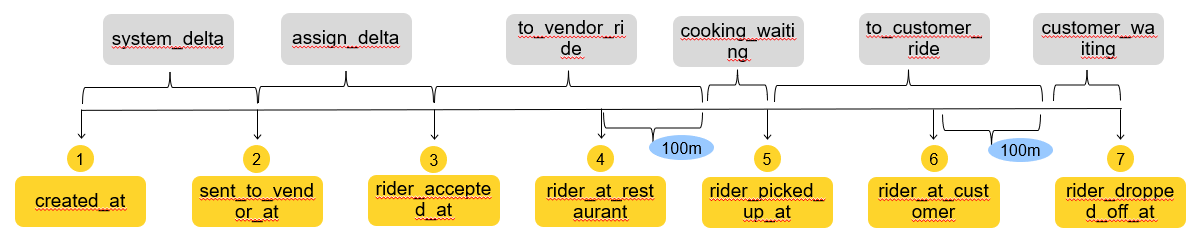

Let's explore the metrics separetely and provide some conclusions at final step.

# Data Preparation

Here we are going to make a dataset for all the metrics that were mentioned above. Only completed orders would be reviewed due to the small number of rejected orders for several reasons (198 out of 10483), it's not enough for any type of conclusion.

In [11]:
df_metrics = df_orders.copy()
df_metrics = df_metrics.query("order_status == 'completed'").reset_index()
df_metrics["system_delta"] = round(((df_metrics["sent_to_vendor_at"] - df_metrics["created_at"]).dt.seconds) / 60, 2)
df_metrics["to_vendor_ride"] = round(((df_metrics["rider_at_restaurant"] - df_metrics["rider_accepted_at"]).dt.seconds + 10) / 60, 2)
df_metrics["cooking_waiting"] = round(((df_metrics["rider_picked_up_at"] - df_metrics["rider_at_restaurant"]).dt.seconds - 10) / 60, 2)
df_metrics["to_customer_ride"] = round(((df_metrics["rider_at_customer"] - df_metrics["rider_picked_up_at"]).dt.seconds + 10) / 60, 2)
df_metrics["customer_waiting"] = round(((df_metrics["rider_dropped_off_at"] - df_metrics["rider_at_customer"]).dt.seconds - 10) / 60, 2)
df_metrics["cooking_time"] = round(((df_metrics["rider_picked_up_at"] - df_metrics["created_at"]).dt.seconds + 10) / 60, 2)

df_metrics["delivery_time"] = round((df_metrics["rider_dropped_off_at"] - df_metrics["created_at"]).dt.seconds / 60, 2)

df_metrics["assign_delta_one"] = (df_metrics["rider_accepted_at"] - df_metrics["sent_to_vendor_at"]).dt.seconds
df_metrics["assign_delta_two"] = (df_metrics["sent_to_vendor_at"] - df_metrics["rider_accepted_at"]).dt.seconds

df_metrics["picked_model_one"] = (df_metrics["rider_picked_up_at"] - df_metrics["expected_pickup_at"]).dt.seconds
df_metrics["picked_model_two"] = (df_metrics["expected_pickup_at"] - df_metrics["rider_picked_up_at"]).dt.seconds

df_metrics["picked_model_ride_one"] = (df_metrics["rider_at_restaurant"] - df_metrics["expected_pickup_at"]).dt.seconds + 10
df_metrics["picked_model_ride_two"] = (df_metrics["expected_pickup_at"] - df_metrics["rider_at_restaurant"]).dt.seconds - 10

df_metrics["promise_model_one"] = (df_metrics["rider_dropped_off_at"] - df_metrics["promised_delivery_time"]).dt.seconds
df_metrics["promise_model_two"] = (df_metrics["promised_delivery_time"] - df_metrics["rider_dropped_off_at"]).dt.seconds

for i in range(df_metrics.shape[0]):
    
    if df_metrics.at[i, "assign_delta_one"] >= df_metrics.at[i, "assign_delta_two"]: 
        df_metrics.at[i, "assign_delta"] = round(df_metrics.at[i, "assign_delta_two"] * (-1) / 60, 2)
    else:
        df_metrics.at[i, "assign_delta"] = round(df_metrics.at[i, "assign_delta_one"] / 60, 2)
    
    if df_metrics.at[i, "picked_model_one"] >= df_metrics.at[i, "picked_model_two"]: 
        df_metrics.at[i, "picked_model"] = round(df_metrics.at[i, "picked_model_two"] * (-1) / 60, 2)
    else:
        df_metrics.at[i, "picked_model"] = round(df_metrics.at[i, "picked_model_one"] / 60, 2)

    if df_metrics.at[i, "picked_model_ride_one"] >= df_metrics.at[i, "picked_model_ride_two"]: 
        df_metrics.at[i, "picked_model_ride"] = round(df_metrics.at[i, "picked_model_ride_two"] * (-1) / 60, 2)
    else:
        df_metrics.at[i, "picked_model_ride"] = round(df_metrics.at[i, "picked_model_ride_one"] / 60, 2)        
        
    if df_metrics.at[i, "promise_model_one"] >= df_metrics.at[i, "promise_model_two"]: 
        df_metrics.at[i, "promise_model"] = round(df_metrics.at[i, "promise_model_two"] * (-1) / 60, 2)
    else:
        df_metrics.at[i, "promise_model"] = round(df_metrics.at[i, "promise_model_one"] / 60, 2)

df_metrics_all = df_metrics.copy()
df_metrics = df_metrics[[
    "city_id", "order_id", "rider_id", "delivery_time", "system_delta", "assign_delta", 
    "to_vendor_ride", "cooking_waiting", "to_customer_ride", "customer_waiting", "picked_model", 
    "picked_model_ride", "promise_model", "cooking_time"
]]
df_metrics.head()

,city_id,order_id,rider_id,delivery_time,system_delta,assign_delta,to_vendor_ride,cooking_waiting,to_customer_ride,customer_waiting,picked_model,picked_model_ride,promise_model,cooking_time
0,3,39051621,523041.0,18.52,0.32,1.85,3.30,4.63,4.17,4.22,0.78,-3.83,0.58,10.28
1,3,39050491,523041.0,23.13,4.68,-1.47,4.53,1.57,6.03,7.77,-5.35,-6.92,3.20,9.48
2,3,39047690,523041.0,49.98,0.63,4.37,5.22,24.42,5.75,9.55,-6.65,-31.08,22.02,34.82
3,3,39046074,523041.0,25.25,1.95,0.65,5.42,5.97,6.05,5.17,-19.90,-25.87,9.30,14.18
4,3,39044703,523041.0,18.80,3.28,0.93,3.93,1.78,8.05,0.77,0.67,-1.12,2.85,10.13


# Metrics distribution

All parts of delivery time are distributed somehow. Here we're going to evaluate the average, median and top 80% of orders.

In [12]:
df_metrics_mean = df_metrics.groupby("city_id").mean().reset_index()
df_metrics_mean["aggregation"] = "mean"

df_metrics_med = df_metrics.groupby("city_id").median().reset_index()
df_metrics_med["aggregation"] = "median"

df_metrics_q = df_metrics.groupby("city_id").quantile(q=0.8).reset_index()
df_metrics_q["aggregation"] = "Q 80%"

df_metrics_agg = pd.concat([df_metrics_med, df_metrics_mean, df_metrics_q])
df_metrics_agg

,city_id,order_id,rider_id,delivery_time,system_delta,assign_delta,to_vendor_ride,cooking_waiting,to_customer_ride,customer_waiting,picked_model,picked_model_ride,promise_model,cooking_time,aggregation
0,3,3.887166e+07,385850.000000,23.120000,1.400000,0.670000,2.220000,6.250000,5.820,2.320000,-1.080000,-6.820000,3.350000,13.470000,median
0,3,3.887585e+07,345896.434137,26.601298,3.348019,2.220027,2.796398,8.162341,6.769,3.276593,-2.241457,-10.421124,5.102529,16.711844,mean
0,3,3.900525e+07,413702.000000,32.580000,2.100000,4.100000,4.620000,12.046000,9.920,4.880000,1.750000,-3.250000,10.022000,20.596000,Q 80%


In [13]:
df_metrics_viz = pd.DataFrame()
df_metrics_viz["aggregation"] = df_metrics_agg["aggregation"]
df_metrics_viz["system_delta"] = df_metrics_agg["system_delta"]
df_metrics_viz["assign_delta"] = df_metrics_agg["system_delta"] + df_metrics_agg["assign_delta"]
df_metrics_viz["to_vendor_ride"] = df_metrics_agg["system_delta"] + df_metrics_agg["assign_delta"] + df_metrics_agg["to_vendor_ride"] 
df_metrics_viz["cooking_waiting"] = df_metrics_agg["system_delta"] + df_metrics_agg["assign_delta"] + df_metrics_agg["to_vendor_ride"] + df_metrics_agg["cooking_waiting"]
df_metrics_viz["to_customer_ride"] = df_metrics_agg["system_delta"] + df_metrics_agg["assign_delta"] + df_metrics_agg["to_vendor_ride"] + df_metrics_agg["cooking_waiting"] + df_metrics_agg["to_customer_ride"]
df_metrics_viz["customer_waiting"] = df_metrics_agg["system_delta"] + df_metrics_agg["assign_delta"] + df_metrics_agg["to_vendor_ride"] + df_metrics_agg["cooking_waiting"] + df_metrics_agg["to_customer_ride"] + df_metrics_agg["customer_waiting"]

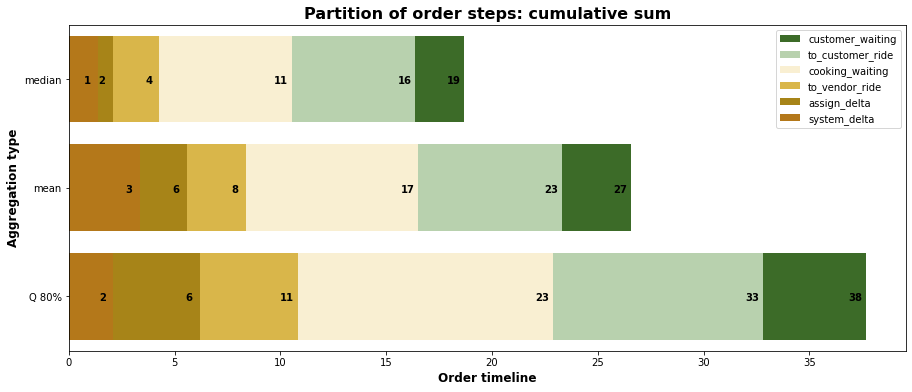

In [14]:
bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "customer_waiting"
    , ci = None
    , palette = ['#38761d']
    , label = "customer_waiting"
    , orient = "h"
)

bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "to_customer_ride"
    , ci = None
    , palette = ['#b6d7a8']
    , label = "to_customer_ride"
    , orient = "h"
)

bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "cooking_waiting"
    , ci = None
    , palette = ['#fff2cc']
    , label = "cooking_waiting"
    , orient = "h"
)

bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "to_vendor_ride"
    , ci = None
    , palette = ['#f1c232']
    , label = "to_vendor_ride"
    , orient = "h"
)

bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "assign_delta"
    , ci = None
    , palette = ['#bf9000']
    , label = "assign_delta"
    , orient = "h"
)

bar_agg = sns.barplot(
    data = df_metrics_viz
    , y = "aggregation"
    , x = "system_delta"
    , ci = None
    , palette = ['#ce7e00']
    , label = "system_delta"
    , orient = "h"
)

for p in bar_agg.patches:
    bar_agg.annotate(
        format(p.get_width(), '.0f')
        , (p.get_width() - 0.5, p.get_y() + 0.4 * p.get_height() ) 
        , ha='center'
        , va='center'
        , xytext=(0, -10)
        , textcoords='offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 10
    )

bar_agg.set_title("Partition of order steps: cumulative sum", fontweight ="bold", size = 16)
bar_agg.set_xlabel("Order timeline", fontweight ="bold", size = 12)
bar_agg.set_ylabel("Aggregation type", fontweight ="bold", size = 12)

bar_agg.legend(ncol = 1, loc="upper right", frameon=True)

All values above are provided in minutes. 

The average (mean) delivery time is 26.6 min, the median is 23.1 min and 80% of orders are delivered in less than 32.6 min.

Just in case: the mean delivery time is the sum of all mean steps, but it doesn’t work for any percentiles. 

Also, I want to mention that system_delta is not a part of UTR but it could influence on the entire delivery time.

In [312]:
df_metrics_count = pd.DataFrame()
df_metrics_count["delivery_time"] = df_metrics["delivery_time"]
df_metrics_count["ride"] = df_metrics["to_vendor_ride"] + df_metrics["to_customer_ride"]
df_metrics_count["not_ride"] = df_metrics["system_delta"] + df_metrics["assign_delta"] + df_metrics["cooking_waiting"] + df_metrics["customer_waiting"]
df_metrics_count["dlv"] = df_metrics_count["ride"] + df_metrics_count["not_ride"] 
df_metrics_count["ride_pcnt"] = df_metrics_count["ride"] / df_metrics_count["dlv"]
df_metrics_count.head()

,delivery_time,ride,not_ride,dlv,ride_pcnt
0,18.52,7.47,11.02,18.49,0.404002
1,23.13,10.56,12.55,23.11,0.456945
2,49.98,10.97,38.97,49.94,0.219664
3,25.25,11.47,13.74,25.21,0.454978
4,18.80,11.98,6.76,18.74,0.639274


In [313]:
np.mean(df_metrics_count["ride_pcnt"])

0.38722808809483256

Only 38.7% of delivery time is spent on rides.

Due two only 2 days in dataset and unexisting of some geoanalytics I'm not going to evaluate riders performance in terms of how fast they are. More than half of delivery time is dedicated to some system and waiting issues, so let's research them.

# System_delta

As it was mentioned preiously that's the timedelta between the order is made by customer and is sent to restaurant.

I'm going to figure out the correlation with time of order and take a look at the overall distribution. All results below are provided in seconds.

In [15]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["system_delta"] = df_metrics_all["system_delta"] * 60
df_system["value"] = "system_delta"

df_system.head()

,created_at,system_delta,value
0,2020-08-24 14:40:25.237,19.2,system_delta
1,2020-08-24 14:18:07.725,280.8,system_delta
2,2020-08-24 13:31:05.873,37.8,system_delta
3,2020-08-24 13:10:31.513,117.0,system_delta
4,2020-08-24 12:53:40.676,196.8,system_delta


In [16]:
df_system_mean = df_system.groupby("value").mean().reset_index()
df_system_mean["aggregation"] = "mean"
df_system_mean = df_system_mean[["aggregation", "system_delta"]]

df_system_med = df_system.groupby("value").median().reset_index()
df_system_med["aggregation"] = "median"
df_system_med = df_system_med[["aggregation", "system_delta"]]

df_system_q = df_system.groupby("value").quantile(q = 0.8).reset_index()
df_system_q["aggregation"] = "Q 80%"
df_system_q = df_system_q[["aggregation", "system_delta"]]

df_system_agg = pd.concat([df_system_med, df_system_mean, df_system_q])
df_system_agg

,aggregation,system_delta
0,median,84.000000
0,mean,200.881125
0,Q 80%,126.000000


In [17]:
df_system["created_str"] = df_system["created_at"].astype('string')
#create numbers and names of days
for i in range(df_system.shape[0]):
    split_list = df_system.at[i, "created_str"].split(" ")
    time = split_list[1]
    split_hour = time.split(":")
    df_system.at[i, "hour"] = split_hour[0]    

df_system.head()

,created_at,system_delta,value,created_str,hour
0,2020-08-24 14:40:25.237,19.2,system_delta,2020-08-24 14:40:25.237,14
1,2020-08-24 14:18:07.725,280.8,system_delta,2020-08-24 14:18:07.725,14
2,2020-08-24 13:31:05.873,37.8,system_delta,2020-08-24 13:31:05.873,13
3,2020-08-24 13:10:31.513,117.0,system_delta,2020-08-24 13:10:31.513,13
4,2020-08-24 12:53:40.676,196.8,system_delta,2020-08-24 12:53:40.676,12


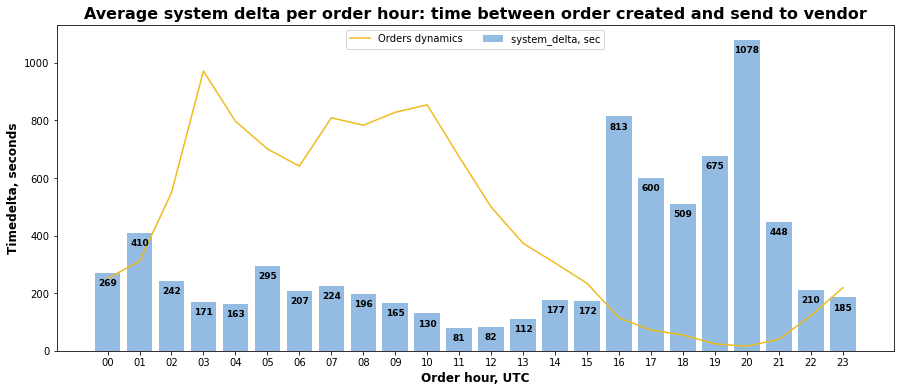

In [18]:
df_system_bar = df_system.groupby("hour").mean()["system_delta"].reset_index()
df_orders_count = df_system.groupby("hour").count()["system_delta"].reset_index()

bar_system = sns.barplot(
    data = df_system_bar
    , x = "hour"
    , y = "system_delta"
    , ci = None
    , palette = ["#87bdef"]
    , label = "system_delta, sec"
)

for p in bar_system.patches:
    bar_system.annotate(
        format(p.get_height(), '.0f')
        , (p.get_x() + p.get_width() / 2., p.get_height())
        , ha = 'center'
        , va = 'center'
        , xytext = (0, -10)
        , textcoords = 'offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 9
    )
    
    
bar_system = sns.lineplot(
    data = df_orders_count
    , x = "hour"
    , y = "system_delta"
    , color = "#efbb1d"
    , label = "Orders dynamics"
    , ci = None
)

bar_system.set_title("Average system delta per order hour: time between order created and send to vendor", fontweight ="bold", size = 16)
bar_system.set_xlabel("Order hour, UTC", fontweight ="bold", size = 12)
bar_system.set_ylabel("Timedelta, seconds", fontweight ="bold", size = 12)
bar_system.legend(ncol = 3, loc = "upper center", frameon = True)

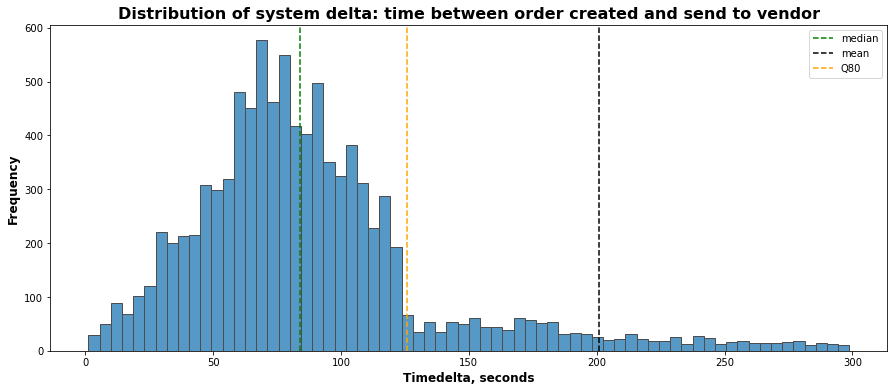

In [19]:
df_system = df_system.query("system_delta < 300")

system_hist = sns.histplot(
    df_system,
    x="system_delta",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = df_system_med.iloc[0]["system_delta"], color = 'green', linestyle = '--', label = 'median')
plt.axvline(x = df_system_mean.iloc[0]["system_delta"], color = 'black', linestyle = '--', label = 'mean')
plt.axvline(x = df_system_q.iloc[0]["system_delta"], color = 'orange', linestyle = '--', label = 'Q80')

system_hist.set_title("Distribution of system delta: time between order created and send to vendor", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, seconds", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

system_hist.legend(ncol = 1, loc="upper right", frameon=True)

The city of the issue belongs to UTC+8 timezone. We can see the large tail of the distribution, which corresponds to midnight. Due to the currently small number of night orders, it almost doesn’t influence the median (84 sec) and Q80 (126 sec) values but increases the average value (200 sec). It would be an issue when the order number rises.

That’s the infrastructure problem, which adds an additional 2–3 minutes to delivery time.

# Cooking_waiting

Some time is spent by rider at resaturant while the orders is cooking. I'm also going to figure out the distribution.

In [361]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["cooking_waiting"] = df_metrics_all["cooking_waiting"]
df_system["value"] = "cooking_waiting"

df_system.head()

,created_at,cooking_waiting,value
0,2020-08-24 14:40:25.237,4.63,cooking_waiting
1,2020-08-24 14:18:07.725,1.57,cooking_waiting
2,2020-08-24 13:31:05.873,24.42,cooking_waiting
3,2020-08-24 13:10:31.513,5.97,cooking_waiting
4,2020-08-24 12:53:40.676,1.78,cooking_waiting


In [362]:
df_system_mean = df_system.groupby("value").mean().reset_index()
df_system_mean["aggregation"] = "mean"
df_system_mean = df_system_mean[["aggregation", "cooking_waiting"]]

df_system_med = df_system.groupby("value").median().reset_index()
df_system_med["aggregation"] = "median"
df_system_med = df_system_med[["aggregation", "cooking_waiting"]]

df_system_q = df_system.groupby("value").quantile(q = 0.8).reset_index()
df_system_q["aggregation"] = "Q 80%"
df_system_q = df_system_q[["aggregation", "cooking_waiting"]]

df_system_agg = pd.concat([df_system_med, df_system_mean, df_system_q])
df_system_agg

,aggregation,cooking_waiting
0,median,6.250000
0,mean,8.162341
0,Q 80%,12.046000


In [363]:
df_system["created_str"] = df_system["created_at"].astype('string')
#create numbers and names of days
for i in range(df_system.shape[0]):
    split_list = df_system.at[i, "created_str"].split(" ")
    time = split_list[1]
    split_hour = time.split(":")
    df_system.at[i, "hour"] = split_hour[0]    

df_system.head()

,created_at,cooking_waiting,value,created_str,hour
0,2020-08-24 14:40:25.237,4.63,cooking_waiting,2020-08-24 14:40:25.237,14
1,2020-08-24 14:18:07.725,1.57,cooking_waiting,2020-08-24 14:18:07.725,14
2,2020-08-24 13:31:05.873,24.42,cooking_waiting,2020-08-24 13:31:05.873,13
3,2020-08-24 13:10:31.513,5.97,cooking_waiting,2020-08-24 13:10:31.513,13
4,2020-08-24 12:53:40.676,1.78,cooking_waiting,2020-08-24 12:53:40.676,12


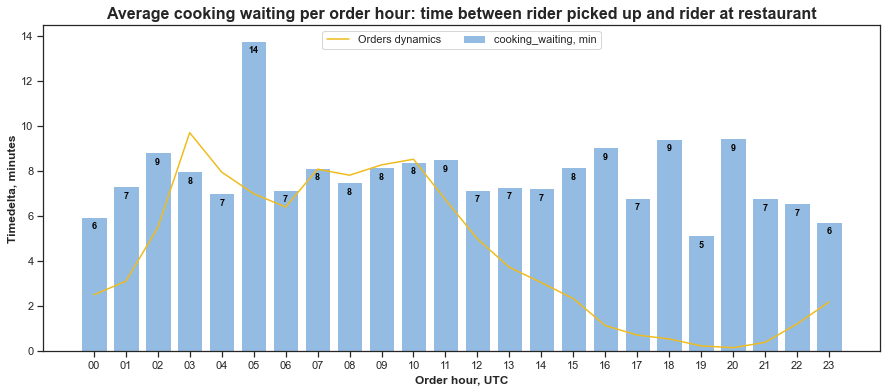

In [364]:
df_system_bar = df_system.groupby("hour").mean()["cooking_waiting"].reset_index()
df_orders_count = df_system.groupby("hour").count()["cooking_waiting"].reset_index()
df_orders_count["cooking_waiting"] = df_orders_count["cooking_waiting"] / 100

bar_system = sns.barplot(
    data = df_system_bar
    , x = "hour"
    , y = "cooking_waiting"
    , ci = None
    , palette = ["#87bdef"]
    , label = "cooking_waiting, min"
)

for p in bar_system.patches:
    bar_system.annotate(
        format(p.get_height(), '.0f')
        , (p.get_x() + p.get_width() / 2., p.get_height())
        , ha = 'center'
        , va = 'center'
        , xytext = (0, -10)
        , textcoords = 'offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 9
    )
    
    
bar_system = sns.lineplot(
    data = df_orders_count
    , x = "hour"
    , y = "cooking_waiting"
    , color = "#efbb1d"
    , label = "Orders dynamics"
    , ci = None
)

bar_system.set_title("Average cooking waiting per order hour: time between rider picked up and rider at restaurant", fontweight ="bold", size = 16)
bar_system.set_xlabel("Order hour, UTC", fontweight ="bold", size = 12)
bar_system.set_ylabel("Timedelta, minutes", fontweight ="bold", size = 12)
bar_system.legend(ncol = 3, loc = "upper center", frameon = True)

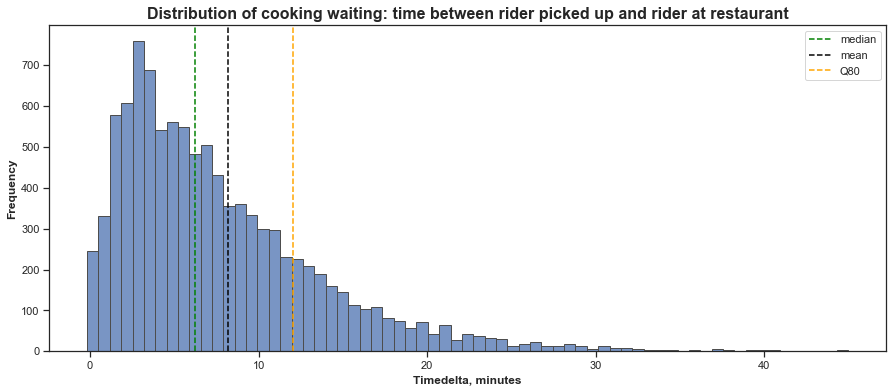

In [365]:
df_system = df_system.query("cooking_waiting < 45")

system_hist = sns.histplot(
    df_system,
    x="cooking_waiting",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = df_system_med.iloc[0]["cooking_waiting"], color = 'green', linestyle = '--', label = 'median')
plt.axvline(x = df_system_mean.iloc[0]["cooking_waiting"], color = 'black', linestyle = '--', label = 'mean')
plt.axvline(x = df_system_q.iloc[0]["cooking_waiting"], color = 'orange', linestyle = '--', label = 'Q80')

system_hist.set_title("Distribution of cooking waiting: time between rider picked up and rider at restaurant", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, minutes", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

system_hist.legend(ncol = 1, loc="upper right", frameon=True)

Riders have to wait for the order for over 8 minutes on average: over 6 minutes in half of all orders and over 12 minutes in 20% of cases.

We can notice it's a regular problem throughout the day.

It could be solved by later assignment to an order. Currently, riders confirm orders almost at the same time as restaurants (sometimes even earlier).

Also, we have a prediction model for the time when the order should be completed by the restaurant. Let's see how close it is.

# picked_model

expected_pickup_at - time vendor is expected to have the meal ready based on out prediction model.

Let's evaluate the timedelta between predicted and fact pick up as well as the timedelta between predicted pick up and the arrival of rider to restaurant. 

In [24]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["picked_model"] = df_metrics_all["picked_model"]
df_system["value"] = "picked_model"

df_system.head()

,created_at,picked_model,value
0,2020-08-24 14:40:25.237,0.78,picked_model
1,2020-08-24 14:18:07.725,-5.35,picked_model
2,2020-08-24 13:31:05.873,-6.65,picked_model
3,2020-08-24 13:10:31.513,-19.90,picked_model
4,2020-08-24 12:53:40.676,0.67,picked_model


Text(0, 0.5, 'Frequency')

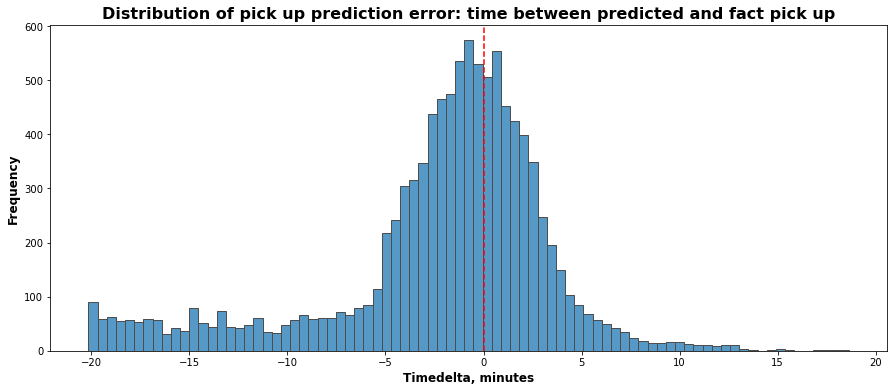

In [25]:
df_system = df_system.query("picked_model > -25 and picked_model < 20")

system_hist = sns.histplot(
    df_system,
    x="picked_model",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = 0, color = 'red', linestyle = '--', label = 'Zero')

system_hist.set_title("Distribution of pick up prediction error: time between predicted and fact pick up", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, minutes", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

In [26]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["picked_model_ride"] = df_metrics_all["picked_model_ride"]
df_system["value"] = "picked_model_ride"

df_system.head()

,created_at,picked_model_ride,value
0,2020-08-24 14:40:25.237,-3.83,picked_model_ride
1,2020-08-24 14:18:07.725,-6.92,picked_model_ride
2,2020-08-24 13:31:05.873,-31.08,picked_model_ride
3,2020-08-24 13:10:31.513,-25.87,picked_model_ride
4,2020-08-24 12:53:40.676,-1.12,picked_model_ride


Text(0, 0.5, 'Frequency')

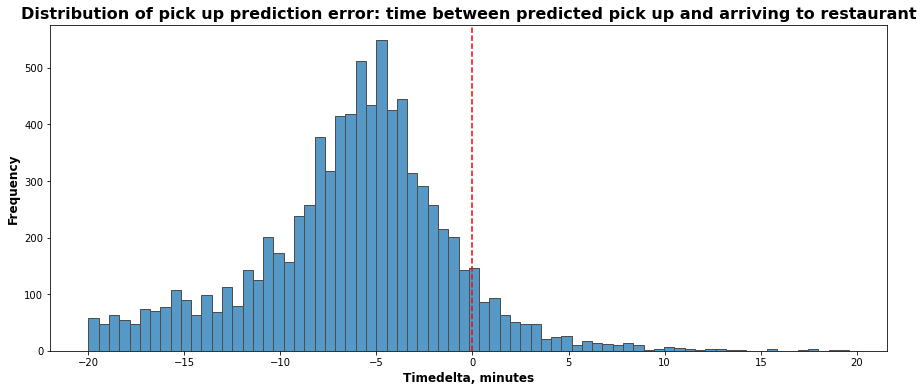

In [27]:
df_system = df_system.query("picked_model_ride > -20 and picked_model_ride < 20")

system_hist = sns.histplot(
    df_system,
    x="picked_model_ride",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = 0, color = 'red', linestyle = '--', label = 'Zero')

system_hist.set_title("Distribution of pick up prediction error: time between predicted pick up and arriving to restaurant", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, minutes", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

The timedelta between predicted and fact pick up and between predicted pick up and the rider’s arrival shows the same bias of 6 minutes.

The right zone in the histogram means that the rider picked the order later than predicted; the left zone means earlier.

From lower chart we can notice that riders arrive before prediction threshold in the biggest part of cases and have to wait the order at restaurant.

In [28]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["picked_model"] = df_metrics_all["picked_model"]
df_system["cooking_time"] = df_metrics_all["cooking_time"]

df_system.head()

,created_at,picked_model,cooking_time
0,2020-08-24 14:40:25.237,0.78,10.28
1,2020-08-24 14:18:07.725,-5.35,9.48
2,2020-08-24 13:31:05.873,-6.65,34.82
3,2020-08-24 13:10:31.513,-19.90,14.18
4,2020-08-24 12:53:40.676,0.67,10.13


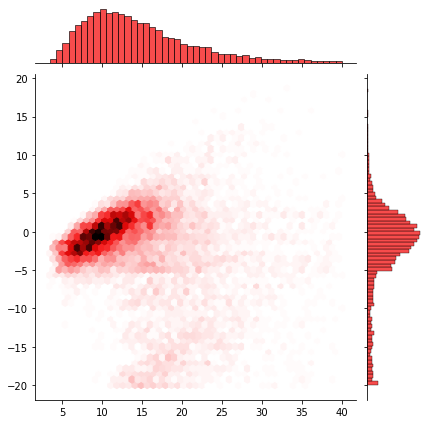

In [29]:
df_system = df_system.query("picked_model < 20 and picked_model > -20 and cooking_time < 40")
x = np.array(df_system["cooking_time"])
y = np.array(df_system["picked_model"])
corr = sns.jointplot(x = x, y = y, kind="hex", color="#f51010")

Above is the correlation between cooking time (h) and prediction error (v) on the red-colored chart. The prediction model could be improved, especially for long-cooked orders, but later rider assignment seems to be a more interesting solution.

# customer_waiting

That's the timedelta of rider waiting for customer to drop off the order.

In [30]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["customer_waiting"] = df_metrics_all["customer_waiting"] 
df_system["value"] = "customer_waiting"

df_system.head()

,created_at,customer_waiting,value
0,2020-08-24 14:40:25.237,4.22,customer_waiting
1,2020-08-24 14:18:07.725,7.77,customer_waiting
2,2020-08-24 13:31:05.873,9.55,customer_waiting
3,2020-08-24 13:10:31.513,5.17,customer_waiting
4,2020-08-24 12:53:40.676,0.77,customer_waiting


In [31]:
df_system_mean = df_system.groupby("value").mean().reset_index()
df_system_mean["aggregation"] = "mean"
df_system_mean = df_system_mean[["aggregation", "customer_waiting"]]

df_system_med = df_system.groupby("value").median().reset_index()
df_system_med["aggregation"] = "median"
df_system_med = df_system_med[["aggregation", "customer_waiting"]]

df_system_q = df_system.groupby("value").quantile(q = 0.8).reset_index()
df_system_q["aggregation"] = "Q 80%"
df_system_q = df_system_q[["aggregation", "customer_waiting"]]

df_system_agg = pd.concat([df_system_med, df_system_mean, df_system_q])
df_system_agg

,aggregation,customer_waiting
0,median,2.320000
0,mean,3.276593
0,Q 80%,4.880000


In [32]:
df_system["created_str"] = df_system["created_at"].astype('string')
#create numbers and names of days
for i in range(df_system.shape[0]):
    split_list = df_system.at[i, "created_str"].split(" ")
    time = split_list[1]
    split_hour = time.split(":")
    df_system.at[i, "hour"] = split_hour[0]    

df_system.head()

,created_at,customer_waiting,value,created_str,hour
0,2020-08-24 14:40:25.237,4.22,customer_waiting,2020-08-24 14:40:25.237,14
1,2020-08-24 14:18:07.725,7.77,customer_waiting,2020-08-24 14:18:07.725,14
2,2020-08-24 13:31:05.873,9.55,customer_waiting,2020-08-24 13:31:05.873,13
3,2020-08-24 13:10:31.513,5.17,customer_waiting,2020-08-24 13:10:31.513,13
4,2020-08-24 12:53:40.676,0.77,customer_waiting,2020-08-24 12:53:40.676,12


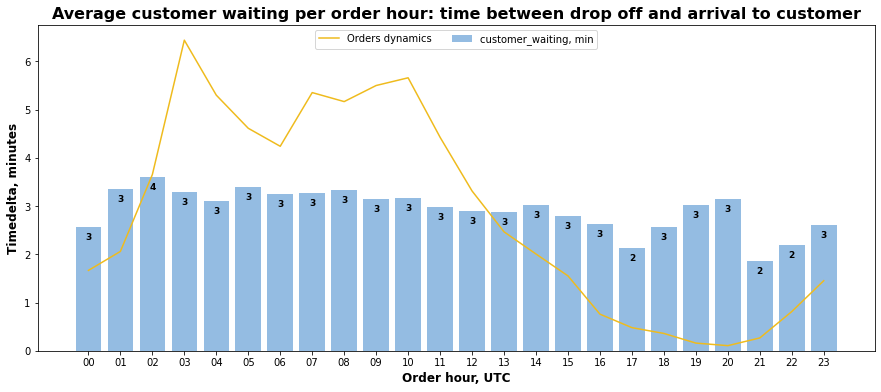

In [36]:
df_system_bar = df_system.groupby("hour").mean()["customer_waiting"].reset_index()
df_orders_count = df_system.groupby("hour").count()["customer_waiting"].reset_index()
df_orders_count["customer_waiting"] = df_orders_count["customer_waiting"] / 150

bar_system = sns.barplot(
    data = df_system_bar
    , x = "hour"
    , y = "customer_waiting"
    , ci = None
    , palette = ["#87bdef"]
    , label = "customer_waiting, min"
)

for p in bar_system.patches:
    bar_system.annotate(
        format(p.get_height(), '.0f')
        , (p.get_x() + p.get_width() / 2., p.get_height())
        , ha = 'center'
        , va = 'center'
        , xytext = (0, -10)
        , textcoords = 'offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 9
    )
    
    
bar_system = sns.lineplot(
    data = df_orders_count
    , x = "hour"
    , y = "customer_waiting"
    , color = "#efbb1d"
    , label = "Orders dynamics"
    , ci = None
)

bar_system.set_title("Average customer waiting per order hour: time between drop off and arrival to customer", fontweight ="bold", size = 16)
bar_system.set_xlabel("Order hour, UTC", fontweight ="bold", size = 12)
bar_system.set_ylabel("Timedelta, minutes", fontweight ="bold", size = 12)
bar_system.legend(ncol = 3, loc = "upper center", frameon = True)

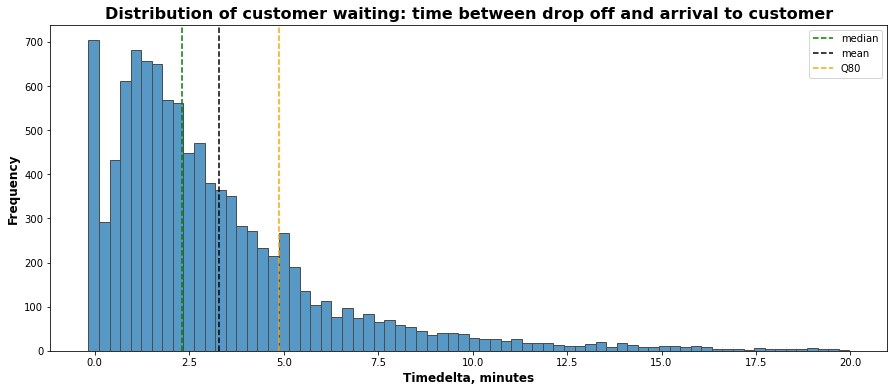

In [35]:
df_system = df_system.query("customer_waiting < 20")

system_hist = sns.histplot(
    df_system,
    x="customer_waiting",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = df_system_med.iloc[0]["customer_waiting"], color = 'green', linestyle = '--', label = 'median')
plt.axvline(x = df_system_mean.iloc[0]["customer_waiting"], color = 'black', linestyle = '--', label = 'mean')
plt.axvline(x = df_system_q.iloc[0]["customer_waiting"], color = 'orange', linestyle = '--', label = 'Q80')

system_hist.set_title("Distribution of customer waiting: time between drop off and arrival to customer", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, minutes", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

system_hist.legend(ncol = 1, loc="upper right", frameon=True)

The timedelta between dropping off the order and arriving to customer could be reduced by ~3 minutes. Regardless the time of order, riders have to wait customer over 2,5 minutes in half of orders, over 3,3 minutes in average and over 5 minutes in 20% of orders.

It could be solved by notification of customer about soon delivery.

It could be solved by more detailed information about the delivery point: probably the rider doesn’t wait for the customer but calls and tries to find the entrance.

We also have some prediction model for the entire delivery time, which is shown to the customer, let's see the correlation of its quality with this waiting time.

# promise_model

promised_delivery_time - initial promise we provide customer when order is placed/created using our prediction models

We are going to evaluate how the timedelta between prediction and fact is distributed. 

In [37]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["promise_model"] = df_metrics_all["promise_model"]
df_system["value"] = "promise_model"

df_system.head()

,created_at,promise_model,value
0,2020-08-24 14:40:25.237,0.58,promise_model
1,2020-08-24 14:18:07.725,3.20,promise_model
2,2020-08-24 13:31:05.873,22.02,promise_model
3,2020-08-24 13:10:31.513,9.30,promise_model
4,2020-08-24 12:53:40.676,2.85,promise_model


Text(0, 0.5, 'Frequency')

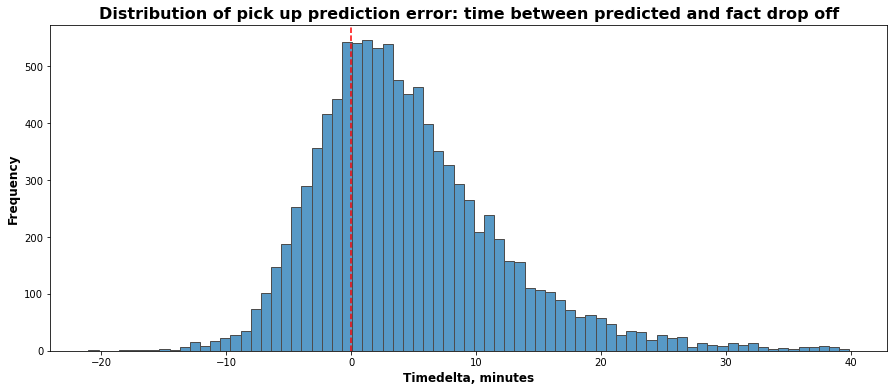

In [38]:
df_system = df_system.query("promise_model > -25 and promise_model < 40")

system_hist = sns.histplot(
    df_system,
    x="promise_model",
    palette="light:m_r",
    edgecolor=".3",
    linewidth= 1,
)

plt.axvline(x = 0, color = 'red', linestyle = '--', label = 'Zero')

system_hist.set_title("Distribution of pick up prediction error: time between predicted and fact drop off", fontweight ="bold", size = 16)
system_hist.set_xlabel("Timedelta, minutes", fontweight ="bold", size = 12)
system_hist.set_ylabel("Frequency", fontweight ="bold", size = 12)

In [39]:
df_system = pd.DataFrame()
df_system["created_at"] = df_metrics_all["created_at"]
df_system["promise_model"] = df_metrics_all["promise_model"]
df_system["customer_waiting"] = df_metrics_all["customer_waiting"]

df_system.head()

,created_at,promise_model,customer_waiting
0,2020-08-24 14:40:25.237,0.58,4.22
1,2020-08-24 14:18:07.725,3.20,7.77
2,2020-08-24 13:31:05.873,22.02,9.55
3,2020-08-24 13:10:31.513,9.30,5.17
4,2020-08-24 12:53:40.676,2.85,0.77


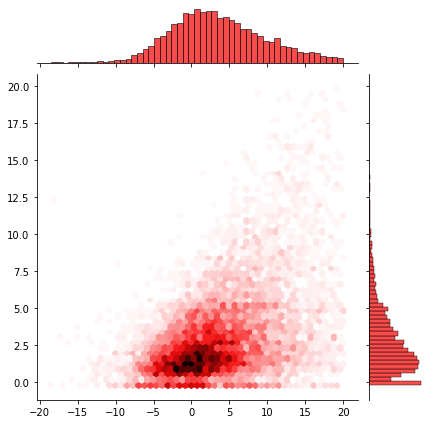

In [40]:
df_system = df_system.query("promise_model < 20 and promise_model > -20 and customer_waiting < 20")
x = np.array(df_system["promise_model"])
y = np.array(df_system["customer_waiting"])
corr = sns.jointplot(x = x, y = y, kind="hex", color="#f51010")

Timedelta of customer waiting correlates with error of predicted delivery – the more delay, the more minutes are spent for dropping.

Seems that hungry and angry customers are not able for fast communication:) 

It could be reduced by the development of the delivery prediction model.

It could be reduced also by fixing the firstly mentioned metric – system_delta, because it’s a part of delivery time. It’s not a part of UTR but can influence on customer waiting time.

According to the previously mentioned data, we can define the average UTR as 1 hour divided by the average delivery time. Excluding the system_delta (3.35 min mean) and starting delivery time for rider from rider_accepted_at till rider_drop_off, consider the avg delivery_time as 23,25 min and **UTR as 2.57**.

# Shifts of Riders

Another point of view is related to the scheduling of riders.

Here I'm going to recalculate the UTR based on scheduled and fact timeshifts and take a look at some of the riders who had planned worktime but didn't start the planned shift.

In [46]:
df_shifts_rid.shape[0]

459

In [47]:
len(np.unique(np.array(df_shifts["rider_id"])))

468

Almost all riders (459 out of 468) delivered at least one order during their planned shifts.

In [48]:
import warnings
warnings.filterwarnings("ignore")

df_shifts_rid = df_shifts.query("shift_state == 'EVALUATED'")
df_shifts_rid["shift_worked"] = (df_shifts_rid["actual_end_at"] - df_shifts_rid["actual_start_at"]).dt.seconds / (60 * 60)

df_shifts_rid = df_shifts_rid.groupby("rider_id").sum()["shift_worked"].reset_index()
df_shifts_rid.head()

,rider_id,shift_worked
0,25642,14.482500
1,48442,17.695278
2,48972,3.133333
3,53623,4.299722
4,54495,8.833056


In [49]:
df_metrics_all["rider_id"] = df_metrics_all["rider_id"].astype('int')
df_orders_rid = df_metrics_all.copy()
df_orders_rid["rider_id"]
df_orders_rid["fact_worked"] = (df_orders_rid["delivery_time"] - df_orders_rid["system_delta"]) / 60

df_orders_rid_sum = (df_orders_rid.groupby(["rider_id"])
                     .sum()["fact_worked"]
                     .reset_index()
                    )

df_orders_rid_cnt = (df_orders_rid.groupby(["rider_id"])
                     .nunique()["order_id"]
                     .reset_index()
                    )

df_orders_rid_stat = pd.merge(df_orders_rid_sum, df_orders_rid_cnt, how = "inner", on = "rider_id")
df_orders_rid_stat.head()

,rider_id,fact_worked,order_id
0,25642,7.644167,17
1,48442,16.379833,47
2,48972,3.962833,12
3,53623,4.153167,15
4,54495,8.800000,16


In [50]:
df_rid = pd.merge(df_orders_rid_stat, df_shifts_rid, how = "inner", on = "rider_id")
df_rid.head()

,rider_id,fact_worked,order_id,shift_worked
0,25642,7.644167,17,14.482500
1,48442,16.379833,47,17.695278
2,48972,3.962833,12,3.133333
3,53623,4.153167,15,4.299722
4,54495,8.800000,16,8.833056


In [51]:
df_rid["UTR_fact"] = df_rid["order_id"] / df_rid["fact_worked"]
df_rid["UTR_shift"] = df_rid["order_id"] / df_rid["shift_worked"]
df_rid.head()

,rider_id,fact_worked,order_id,shift_worked,UTR_fact,UTR_shift
0,25642,7.644167,17,14.482500,2.223918,1.173830
1,48442,16.379833,47,17.695278,2.869382,2.656076
2,48972,3.962833,12,3.133333,3.028136,3.829787
3,53623,4.153167,15,4.299722,3.611702,3.488597
4,54495,8.800000,16,8.833056,1.818182,1.811378


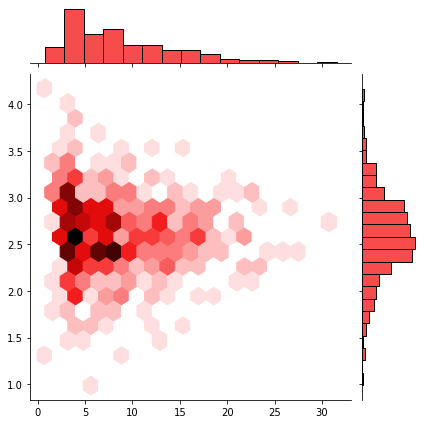

In [52]:
y = np.array(df_rid["UTR_fact"])
x = np.array(df_rid["fact_worked"])
corr = sns.jointplot(x = x, y = y, kind="hex", color="#f51010")

We can notice there is not a strong correlation between worked hours (h) and UTR (v). However, 2 days is a small interval for any additional conclusions.

It's also confirmed by almost the same UTR rates for fact and planned timeshifts.

In [55]:
df_rid["value"] = 'utr'

df_rid_mean = df_rid.groupby("value").mean().reset_index()
df_rid_mean["aggregation"] = "mean"
df_rid_mean = df_rid_mean[["aggregation", "UTR_fact"]]

df_rid_med = df_rid.groupby("value").median().reset_index()
df_rid_med["aggregation"] = "median"
df_rid_med = df_rid_med[["aggregation", "UTR_fact"]]

df_rid_q = df_rid.groupby("value").quantile(q = 0.8).reset_index()
df_rid_q["aggregation"] = "Q 80%"
df_rid_q = df_rid_q[["aggregation", "UTR_fact"]]

df_rid_agg = pd.concat([df_rid_med, df_rid_mean, df_rid_q])
df_rid_agg

,aggregation,UTR_fact
0,median,2.599772
0,mean,2.597853
0,Q 80%,2.934697


In [56]:
df_rid["value"] = 'utr'

df_rid_mean = df_rid.groupby("value").mean().reset_index()
df_rid_mean["aggregation"] = "mean"
df_rid_mean = df_rid_mean[["aggregation", "UTR_shift"]]

df_rid_med = df_rid.groupby("value").median().reset_index()
df_rid_med["aggregation"] = "median"
df_rid_med = df_rid_med[["aggregation", "UTR_shift"]]

df_rid_q = df_rid.groupby("value").quantile(q = 0.8).reset_index()
df_rid_q["aggregation"] = "Q 80%"
df_rid_q = df_rid_q[["aggregation", "UTR_shift"]]

df_rid_agg = pd.concat([df_rid_med, df_rid_mean, df_rid_q])
df_rid_agg

,aggregation,UTR_shift
0,median,2.411791
0,mean,2.433125
0,Q 80%,2.798802


So, I'm not going to consider the data related to riders as an issue, the same can be said regarding supply-demand balance (I have a separate issue related to it at Git): two days seem to be too few for it.

# Key Conclusions

The following improvements could increase the rider's performance:
- Later rider’s assignment to order => decrease time of waiting at restaurant (~8 min); 
- Notifications close before delivery and fixing infrastructure cases of sending orders to restaurants => save time for waiting customer (~2 min).
- Improvement of both prediction models increase chances for success of two points above.
- In the most optimistic scenario, we will save about 10 minutes on average and increase UTR to 4.5.